In [1]:
# Libraries

import itertools
import numpy
import os
import pandas
import platform
import pickle
import shutil
import sklearn
import sys

In [2]:
# Classes

from sklearn.preprocessing import LabelBinarizer
from pandas                import DataFrame

In [3]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [4]:
# Code

from source.python.data.feature import annodata as data_anndata
from source.python.data.feature import target   as data_target
from source.python.io           import loader   as data_loader
from source.python.io           import writer   as data_writer

# 1. Setup

In [5]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA   = os.path.join(OUT,      'nbp05-target')
OUT_PLOT   = os.path.join(OUT_DATA, 'plot')
RES_NBP02  = os.path.join(OUT,      'nbp02-anndata')
RES_NBP04  = os.path.join(OUT,      'nbp04-feature')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature


In [6]:
# Load the annotated and cleaned data

anndata = data_loader.load_h5ad(
	filename = os.path.join(RES_NBP04, 'arabidopsis-r36.h5ad')
)

feature_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

feature_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

In [7]:
# Load anndata information

mapping_layer   = data_loader.load_json(filename = os.path.join(RES_NBP02, 'layer-mapping.json'))
factor_boxcox   = data_loader.load_json(filename = os.path.join(RES_NBP02, 'factors-boxcox.json'))
factor_normal   = data_loader.load_json(filename = os.path.join(RES_NBP02, 'factors-normal.json'))
factor_standard = data_loader.load_json(filename = os.path.join(RES_NBP02, 'factors-standard.json'))

In [8]:
# Constants

TARGET_LAYER = 'boxcox1p'

# 2. Regression

In [9]:
# Extract the transcript tpm values

values, order = data_target.extract_tpm_multi(
	data      = anndata,
	layer     = TARGET_LAYER,
	groups    = ['Tissue', 'Age', 'Group', 'Perturbation'],
	functions = [
		('max',  lambda x : numpy.max(x, axis = 0)),
		('mean', lambda x : numpy.mean(x, axis = 0))
	]
)

In [10]:
# Define what values to filter out (none means keep all)

filters = {
	'tissue'       : None,
	'age'          : None,
	'group'        : ['mature_leaf', 'mature_flower', 'mature_root', 'mature_seed', 'young_seedling'],
	'perturbation' : None
}

for key, keep in filters.items() :
	if keep is None :
		continue

	index = [order[key].index(x) for x in keep]
	order[key] = keep

	for transcript in values.keys() :
		for group, array in values[transcript].items() :
			if not group.startswith(key.lower()) :
				continue

			values[transcript][group] = [array[x] for x in index]

In [11]:
# Display an example of the transcript tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(values[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:5.3f}'.format(x) for x in value))

tissue-max        : [ 5] 2.301 2.857 2.988 2.711 2.907
tissue-mean       : [ 5] 1.568 1.301 2.219 1.464 1.715
age-max           : [ 4] 2.880 2.857 1.880 2.988
age-mean          : [ 4] 1.521 1.697 1.400 1.921
group-max         : [ 5] 2.789 2.301 2.872 1.880 2.907
group-mean        : [ 5] 1.261 1.593 2.248 1.334 1.792
perturbation-max  : [ 7] 2.988 2.860 2.586 2.880 2.646 2.659 2.727
perturbation-mean : [ 7] 1.921 1.574 2.043 1.631 1.409 1.394 1.573


## 2.1 Distributions

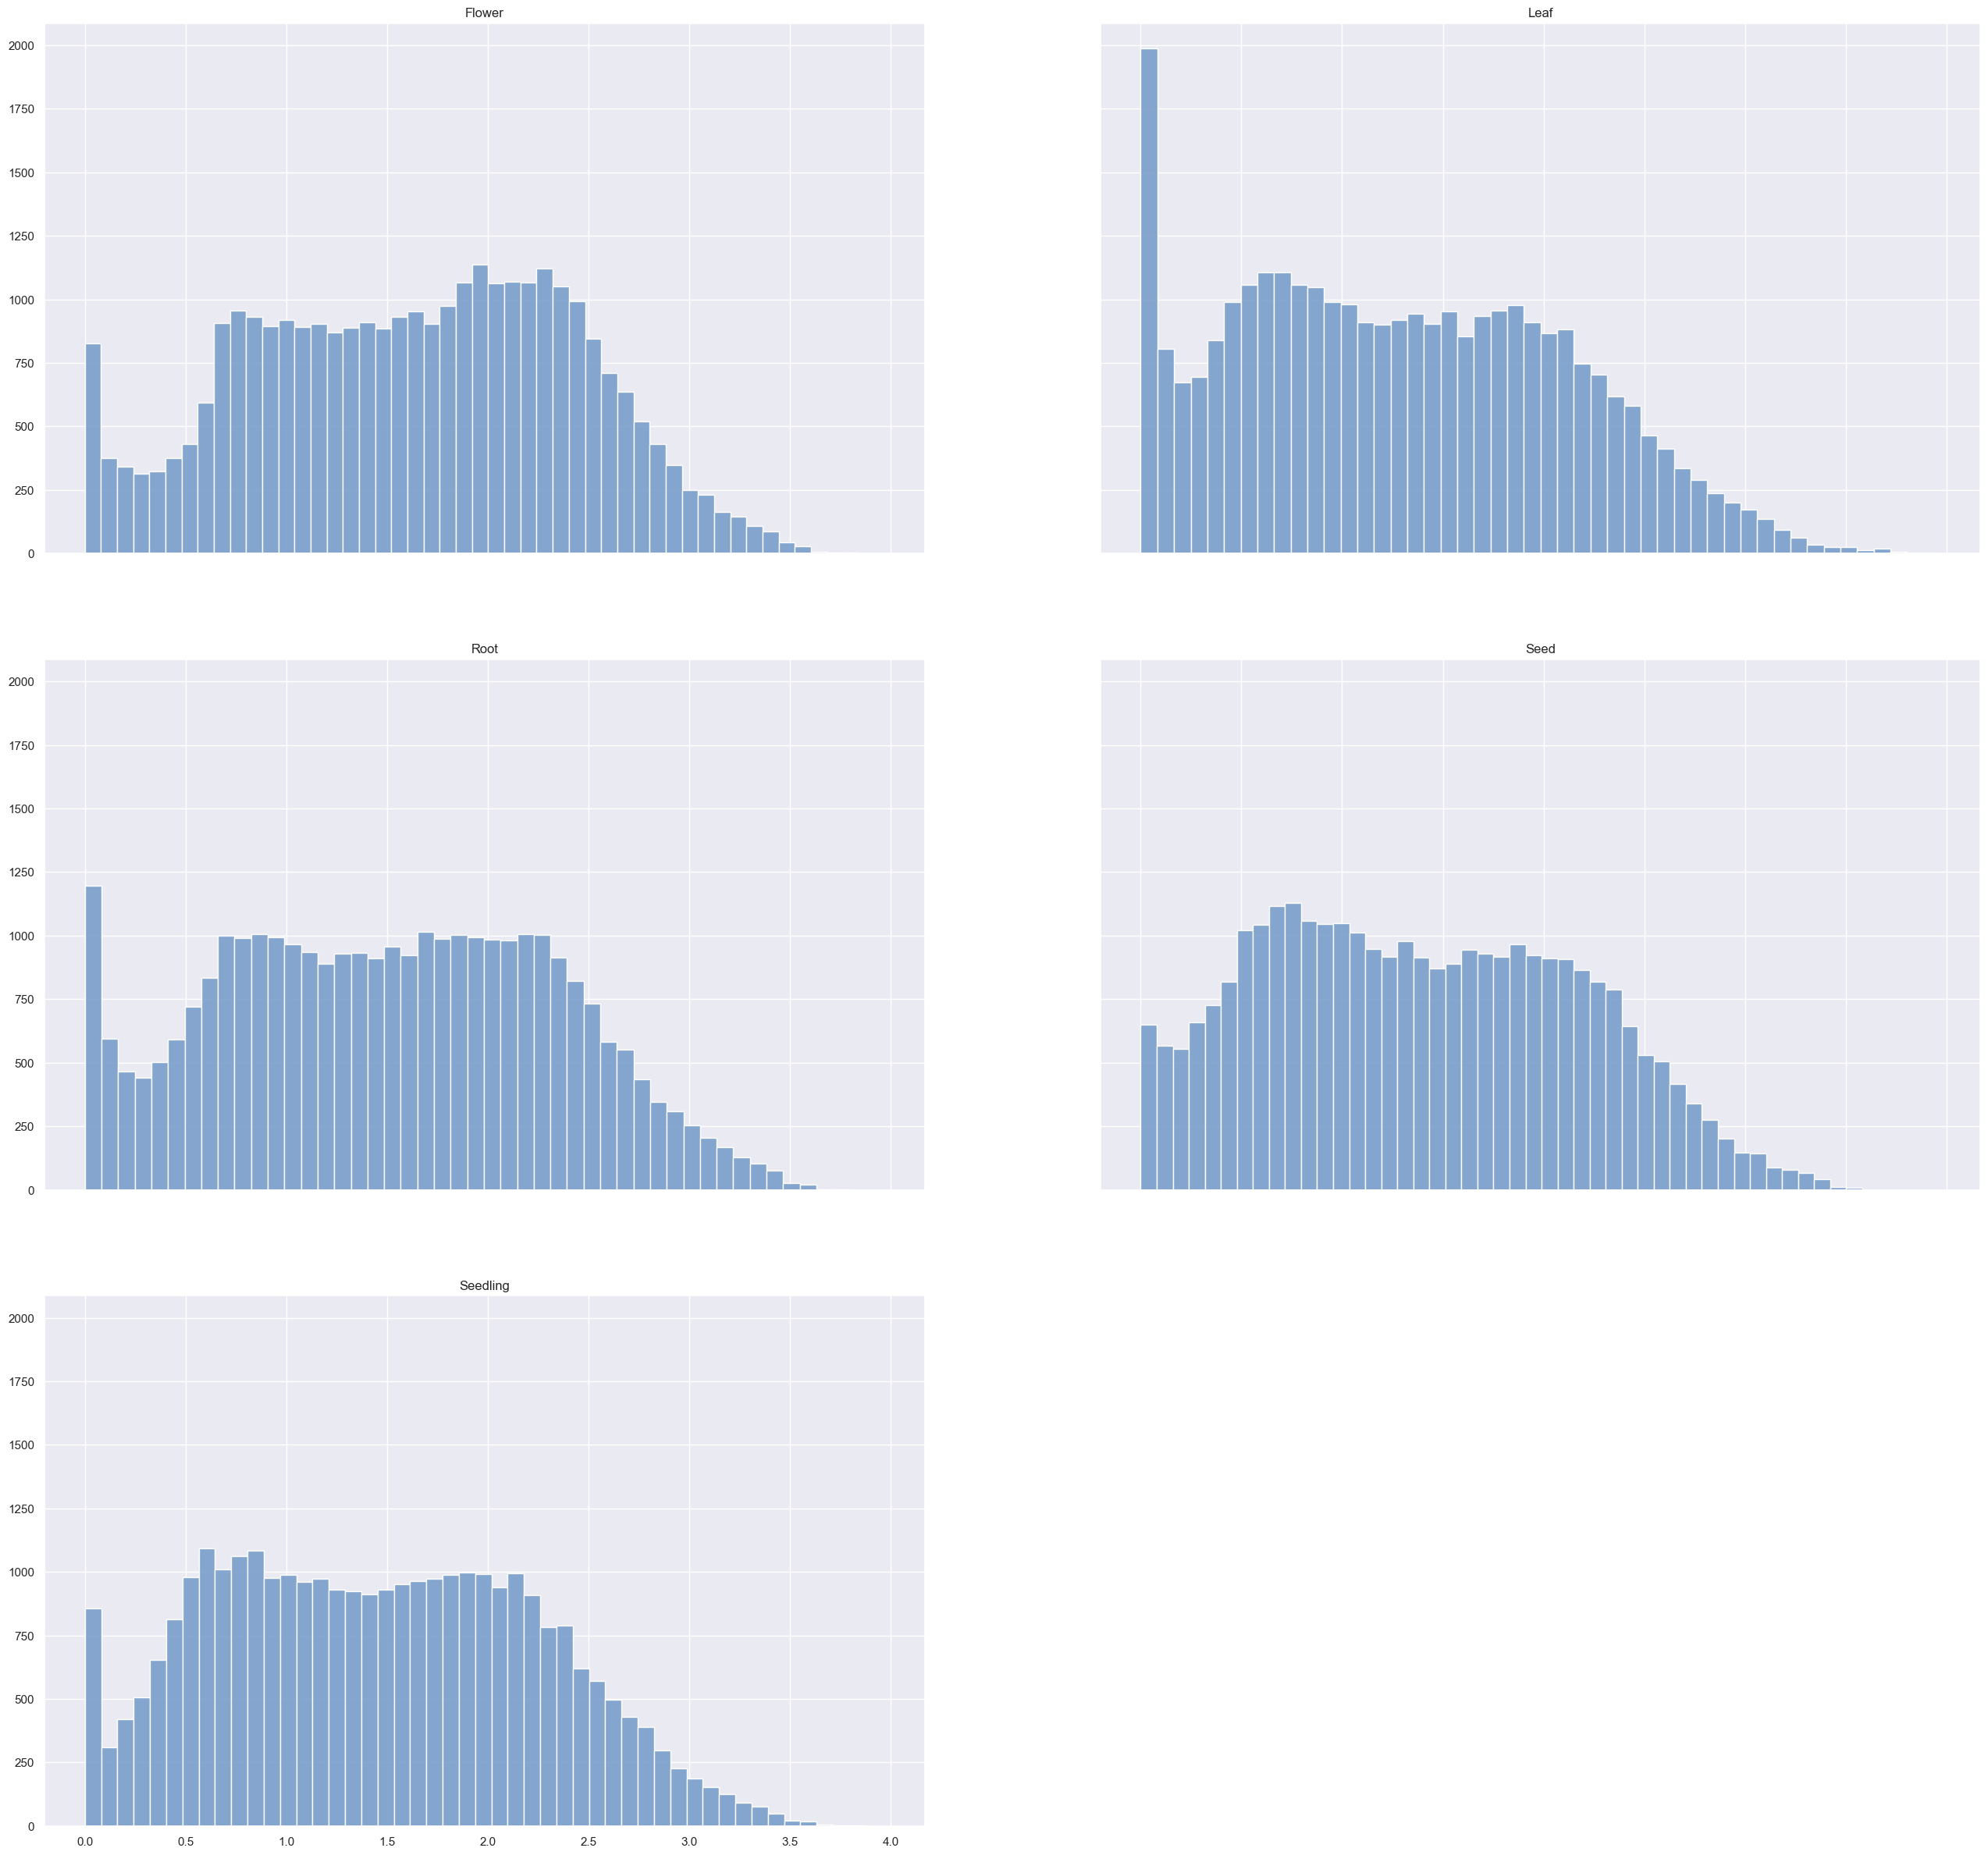

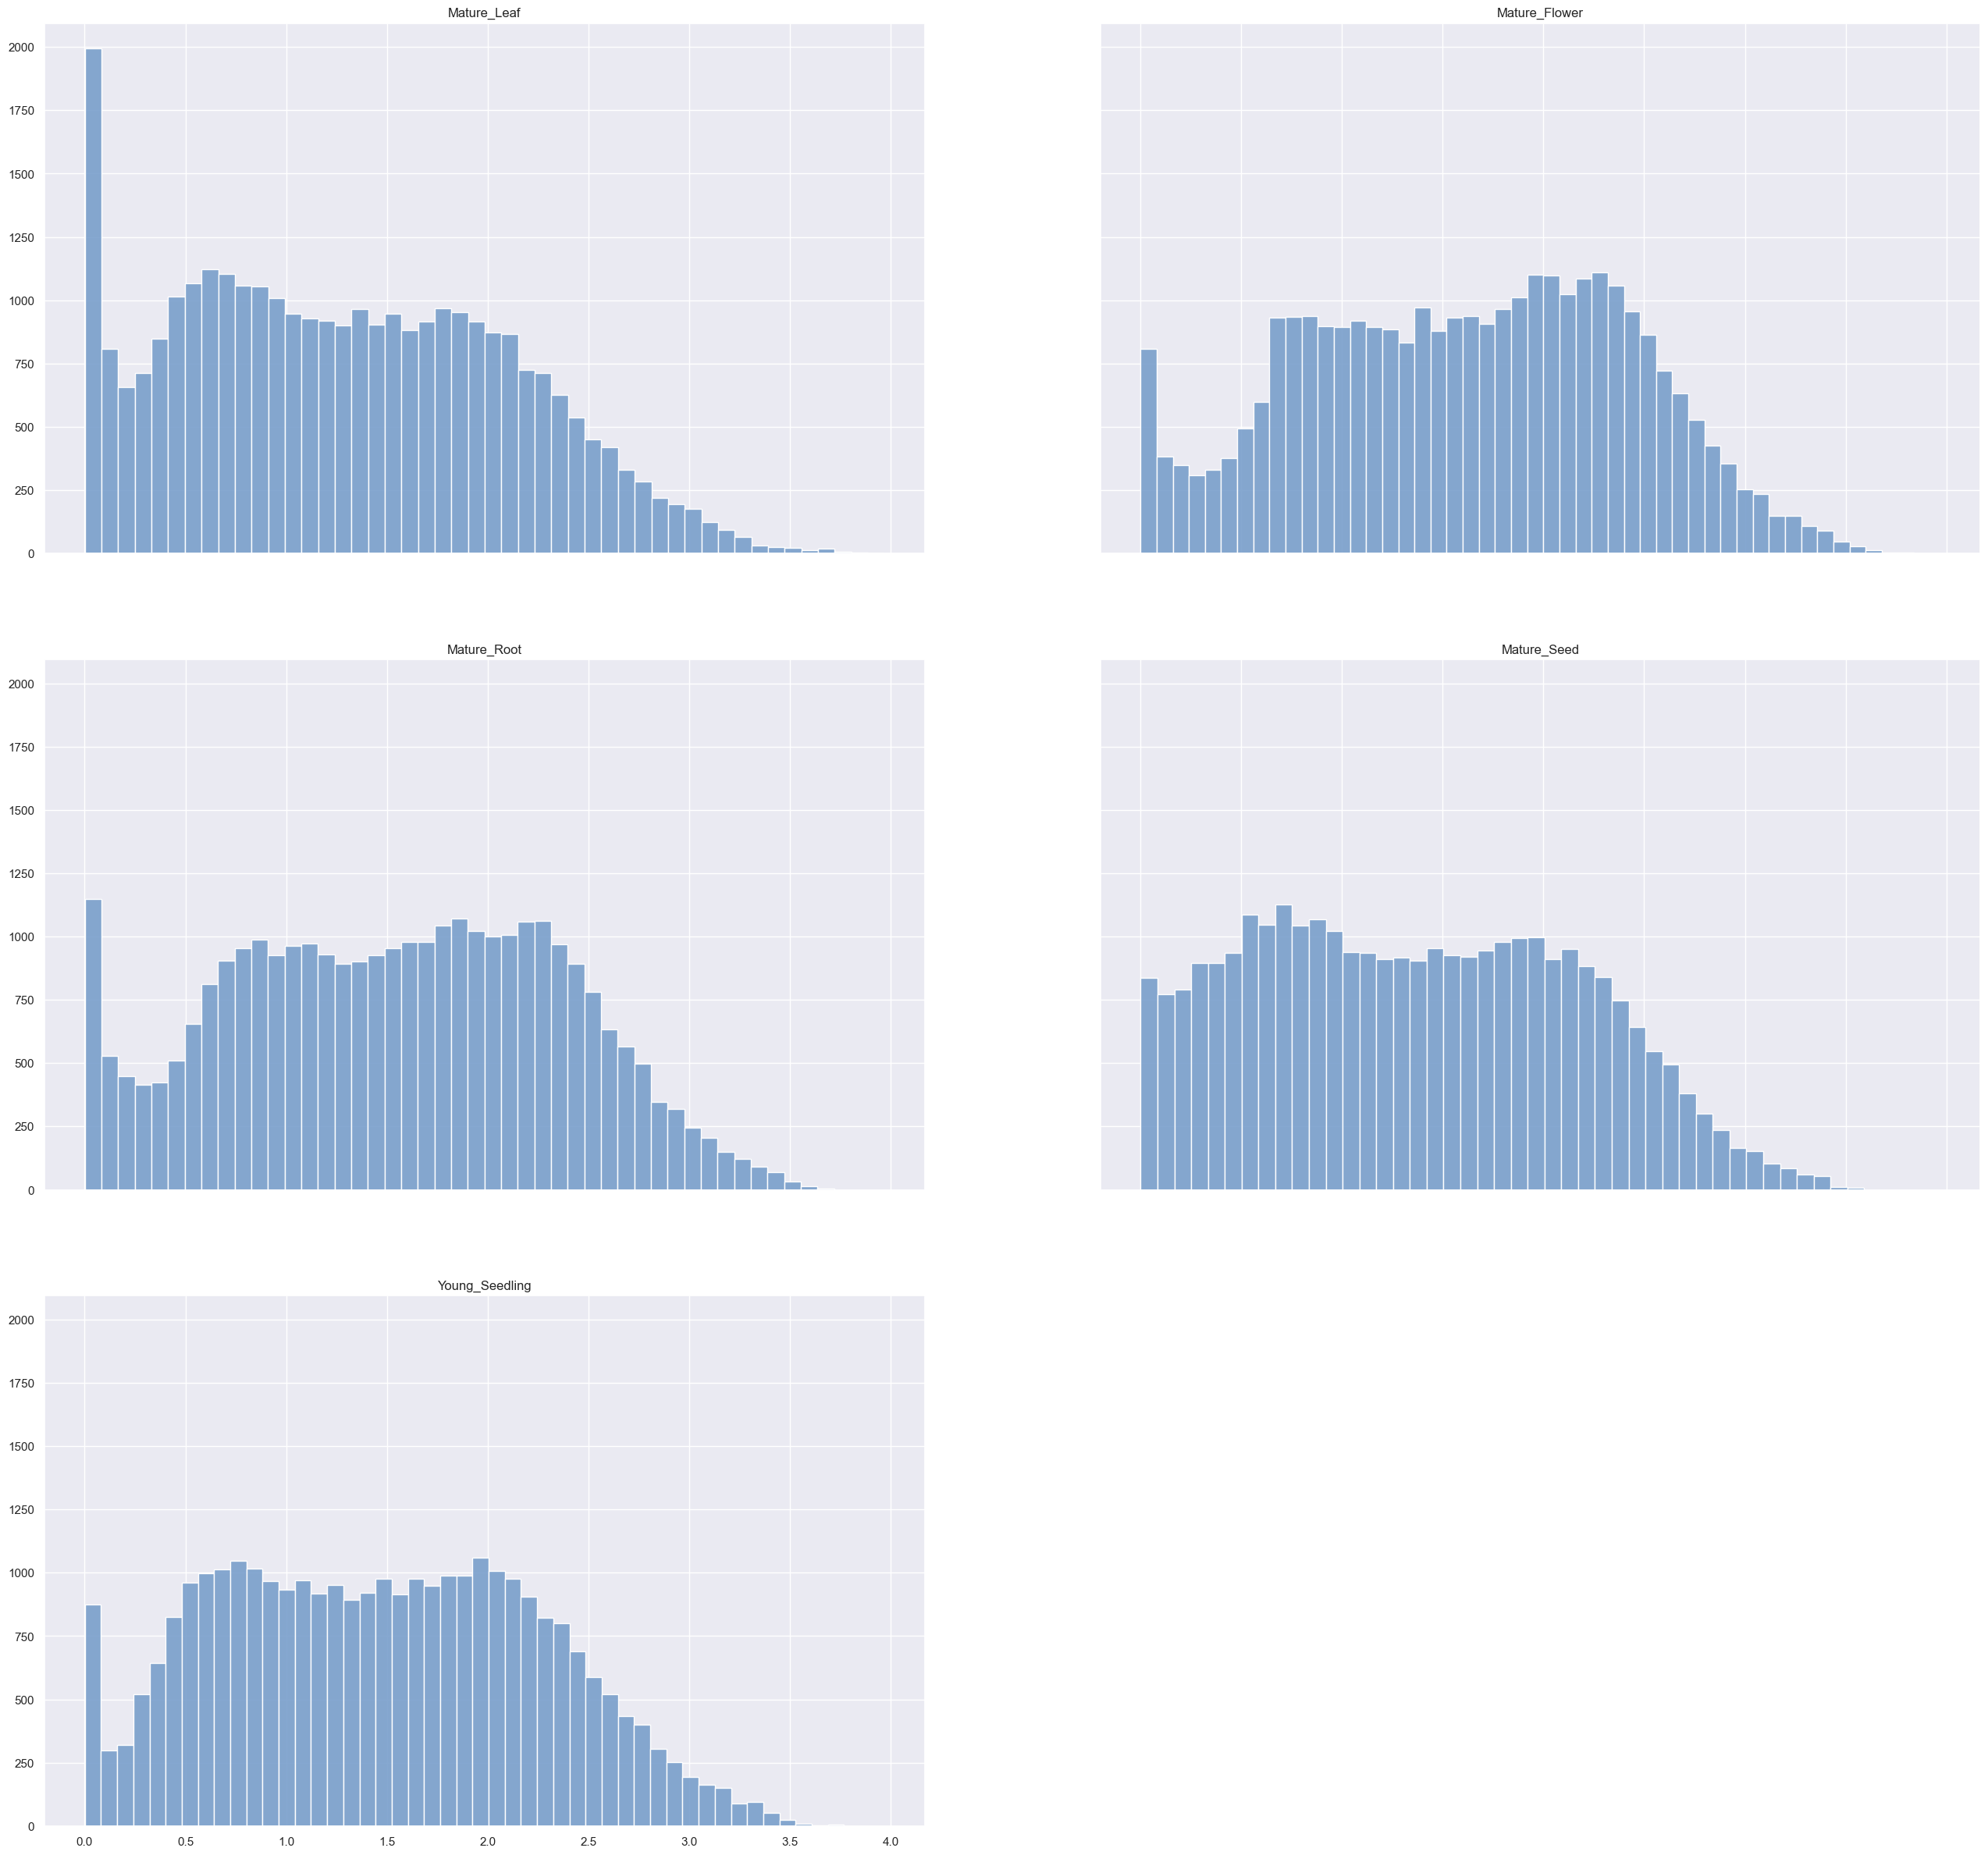

In [12]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-mean')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'group',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-group-mean')
)

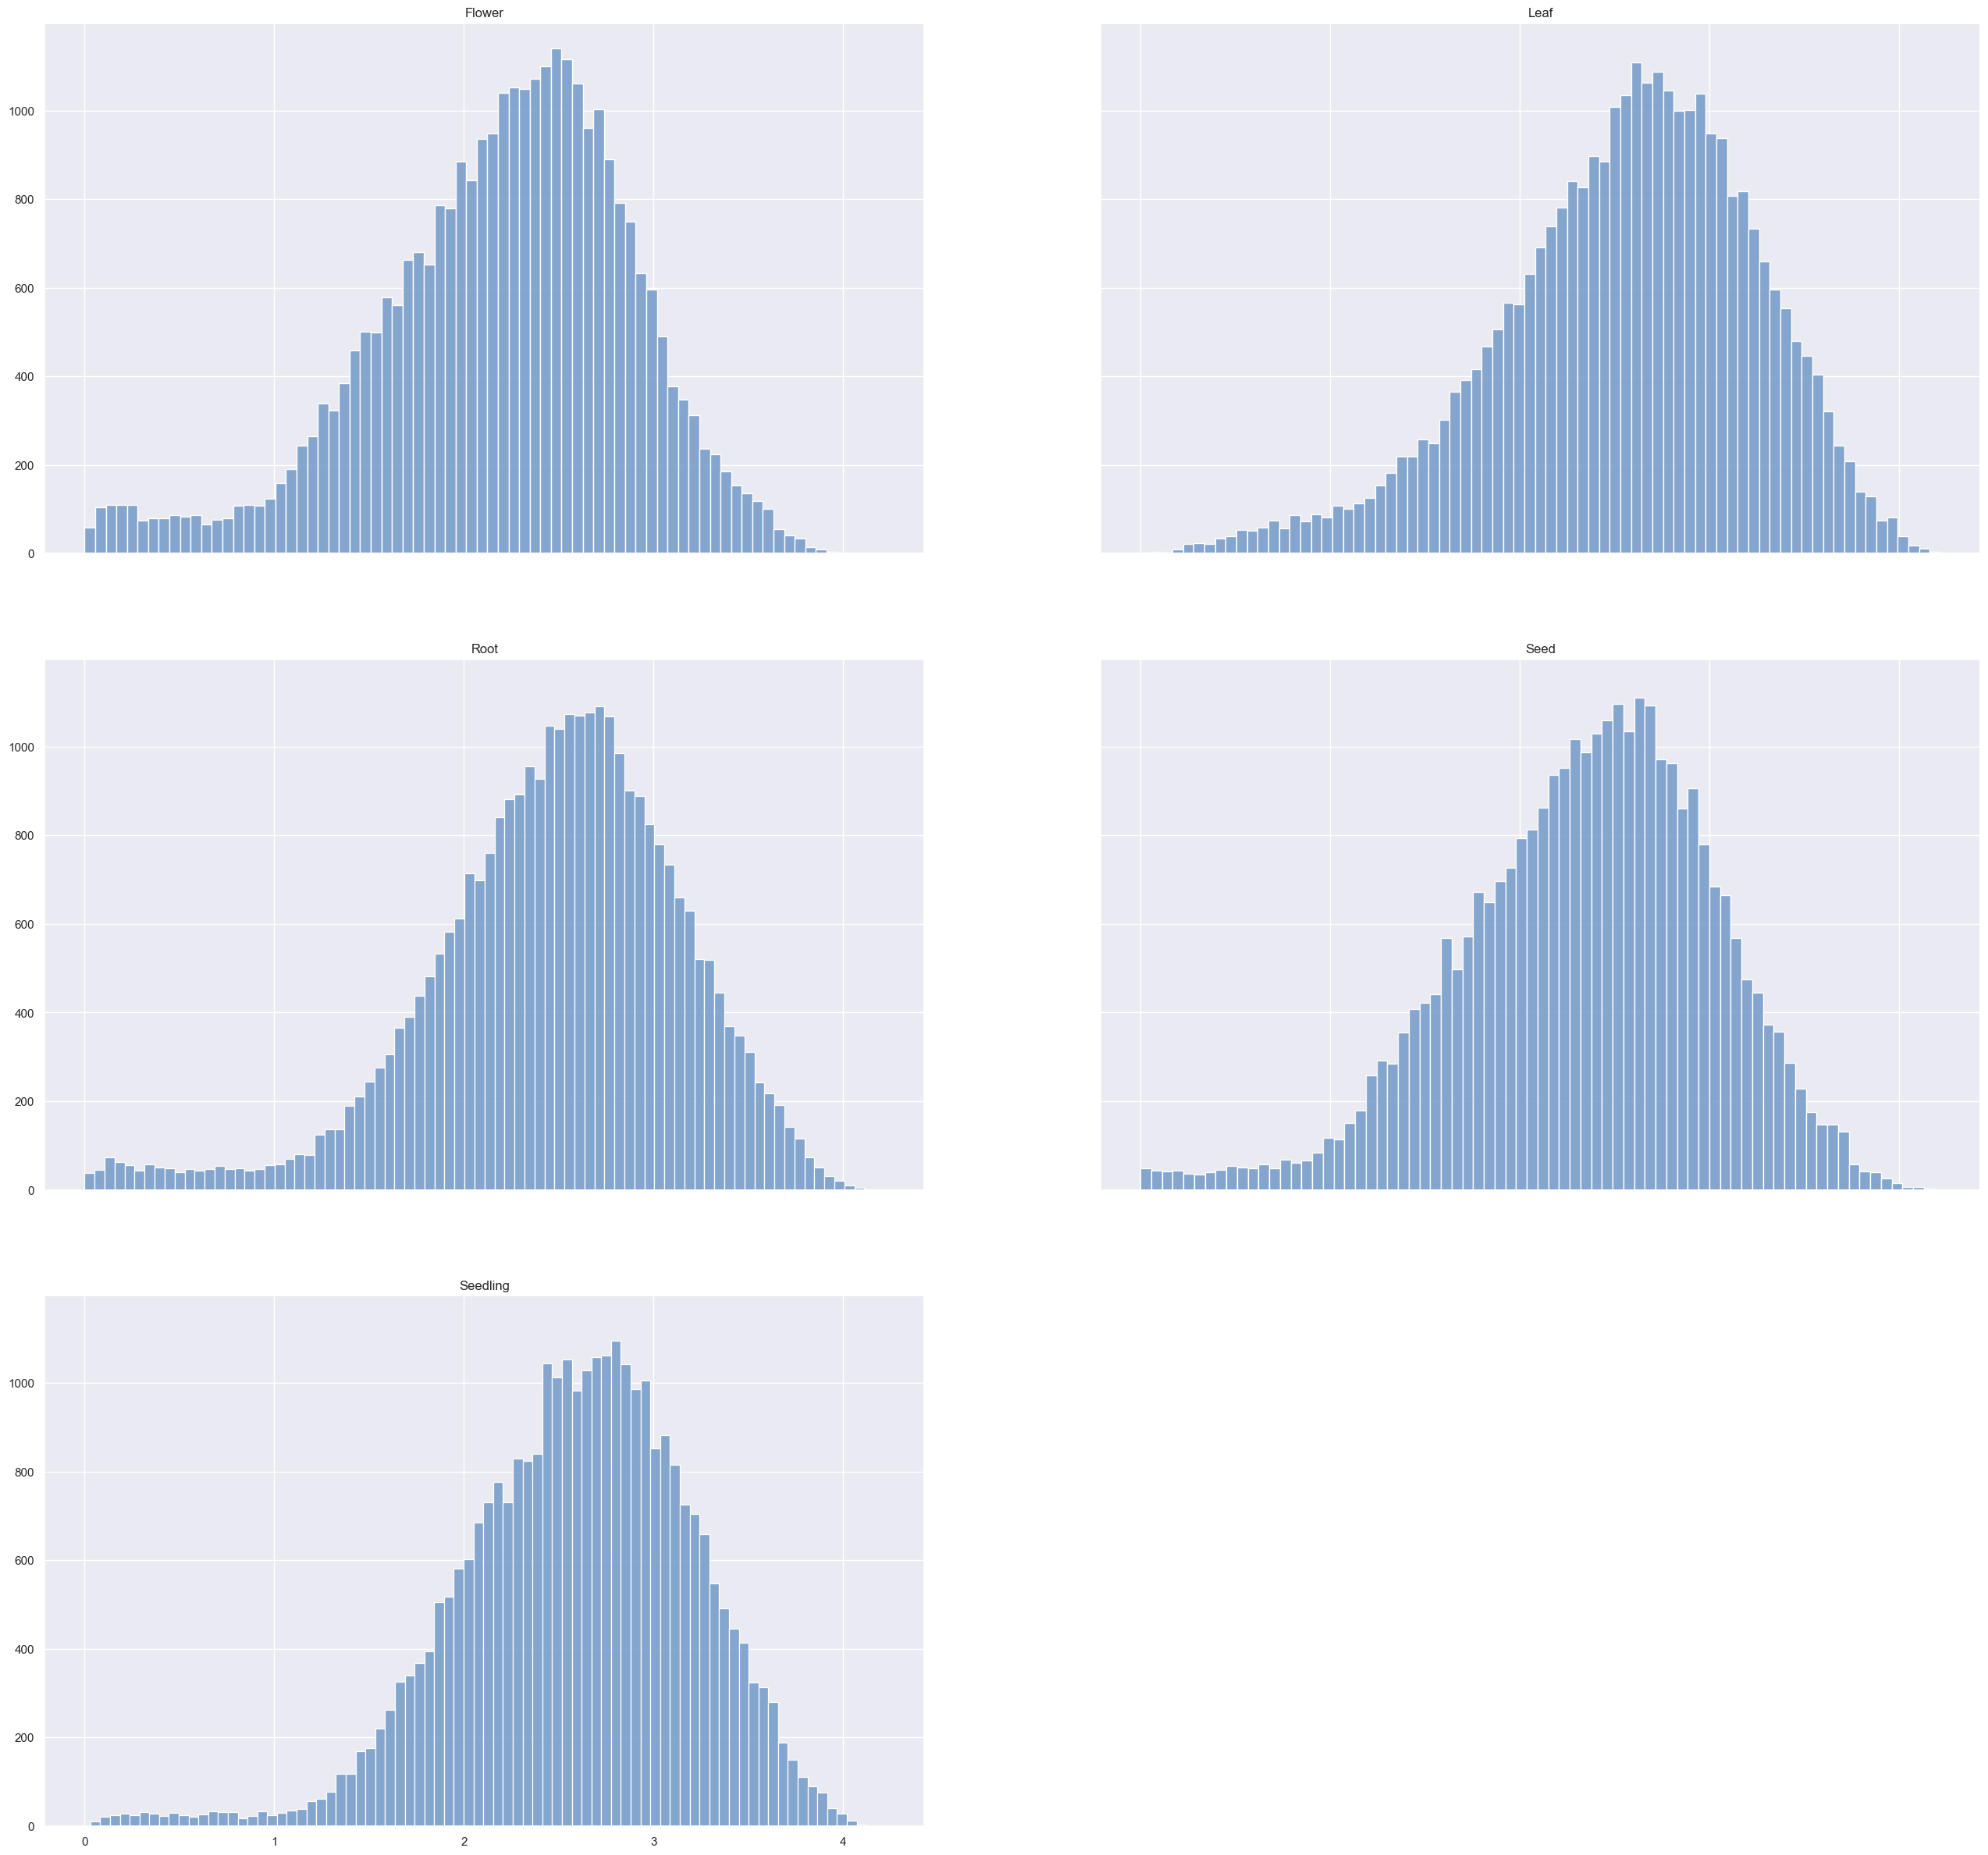

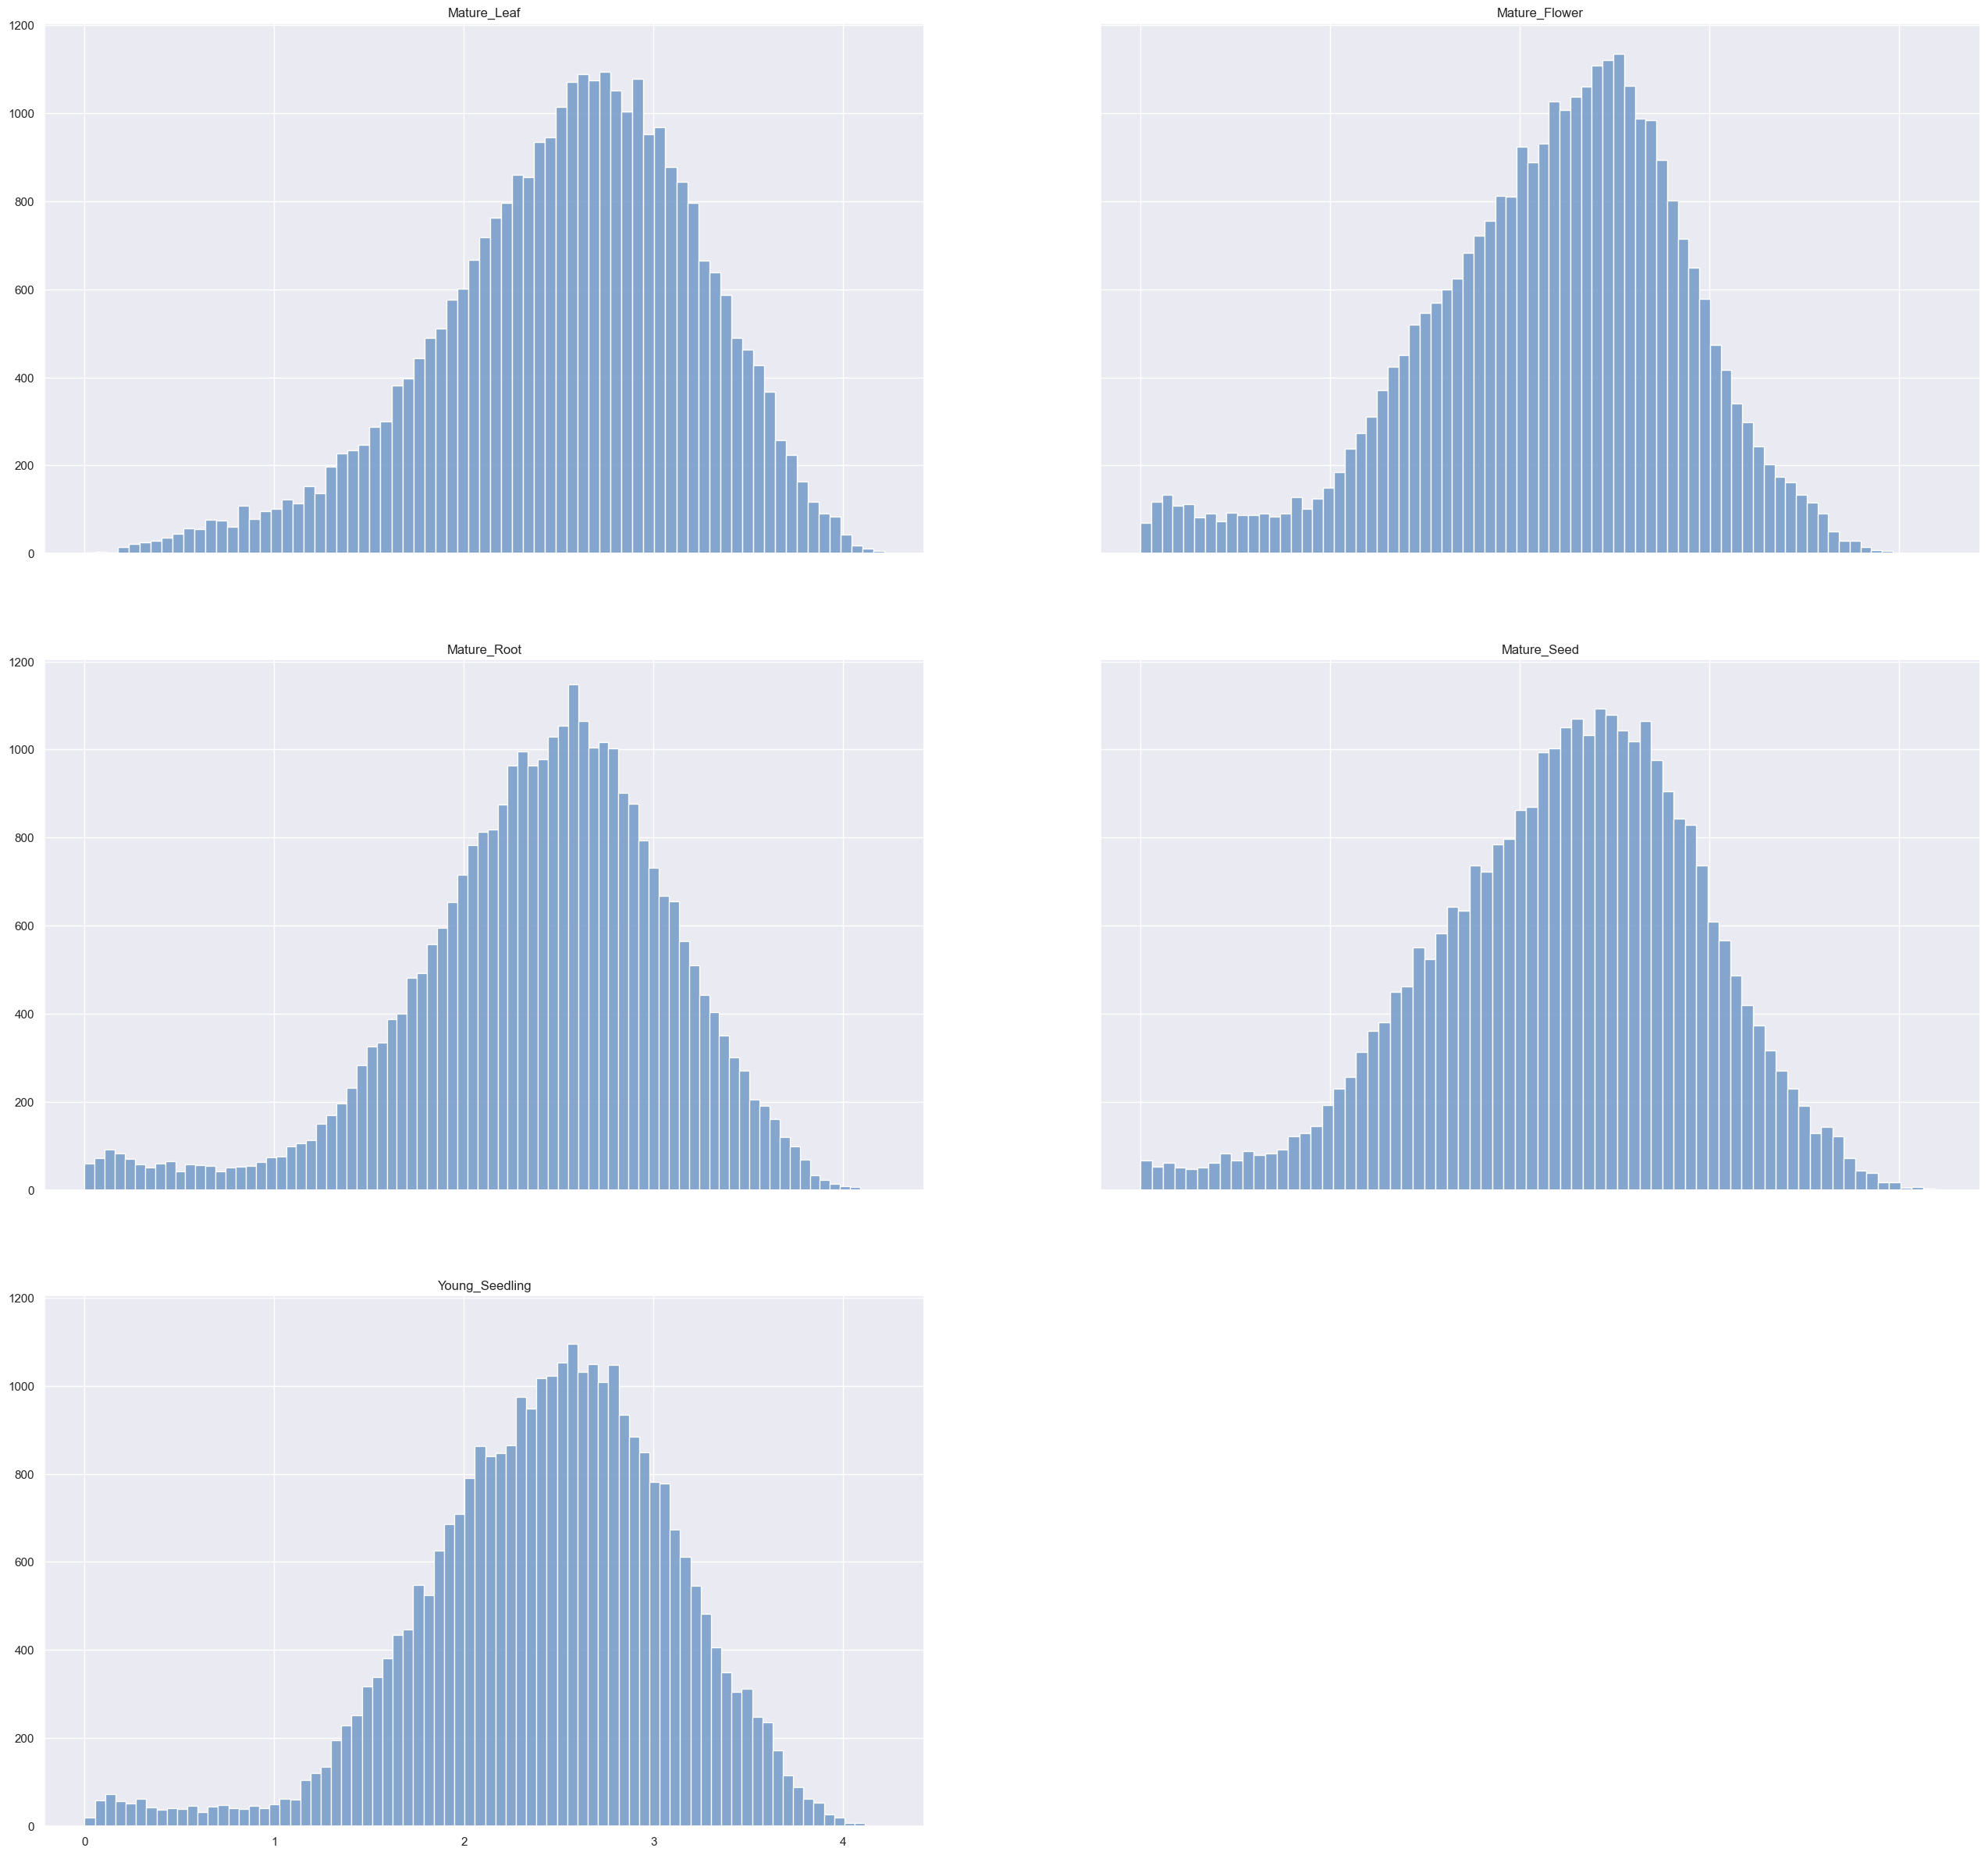

In [13]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'max',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-max')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'group',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-group-max')
)

## 2.2 Save

In [14]:
# Save the target transcript tpm values

data_writer.write_json(
	data     = values,
	filename = os.path.join(OUT_DATA, 'target-values.json')
)

data_writer.write_json(
	data     = order,
	filename = os.path.join(OUT_DATA, 'target-order.json')
)

# 3. Classification

In [15]:
# Extract the transcript tpm classification per group (reuses tpm values from regression extraction)

labels, bounds = data_target.classify_tpm(
	data    = values,
	classes = 3
)

In [16]:
# Display bounds in different configurations (start, values and mapping are manually set based on nbp02-anndata)

data_target.display_bounds_mapping(
	bounds     = bounds['tissue-mean'],
	start      = TARGET_LAYER,
	values = {
		'min_value'  : factor_normal['min'],
		'max_value'  : factor_normal['max'],
		'box_lambda' : factor_boxcox['lambda'],
		'log_base'   : 2
	},
	mapping = mapping_layer
)

                             boxcox1p |                           tpm
---------------------------------------------------------------------
level-0       0.00022 -       1.00011 |       0.00022 -       2.09524
level-1       1.00011 -       1.87835 |       2.09524 -      10.30421
level-2       1.87835 -       3.96912 |      10.30421 -  12,573.04171


In [17]:
# Display an example of the transcript classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(labels[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-max        : [ 5] 1 2 2 1 2
tissue-mean       : [ 5] 1 1 2 1 1
age-max           : [ 4] 2 2 0 2
age-mean          : [ 4] 1 1 1 2
group-max         : [ 5] 2 1 2 0 2
group-mean        : [ 5] 1 1 2 1 1
perturbation-max  : [ 7] 2 2 1 2 1 1 1
perturbation-mean : [ 7] 2 1 2 1 1 1 1


## 3.1 Distributions

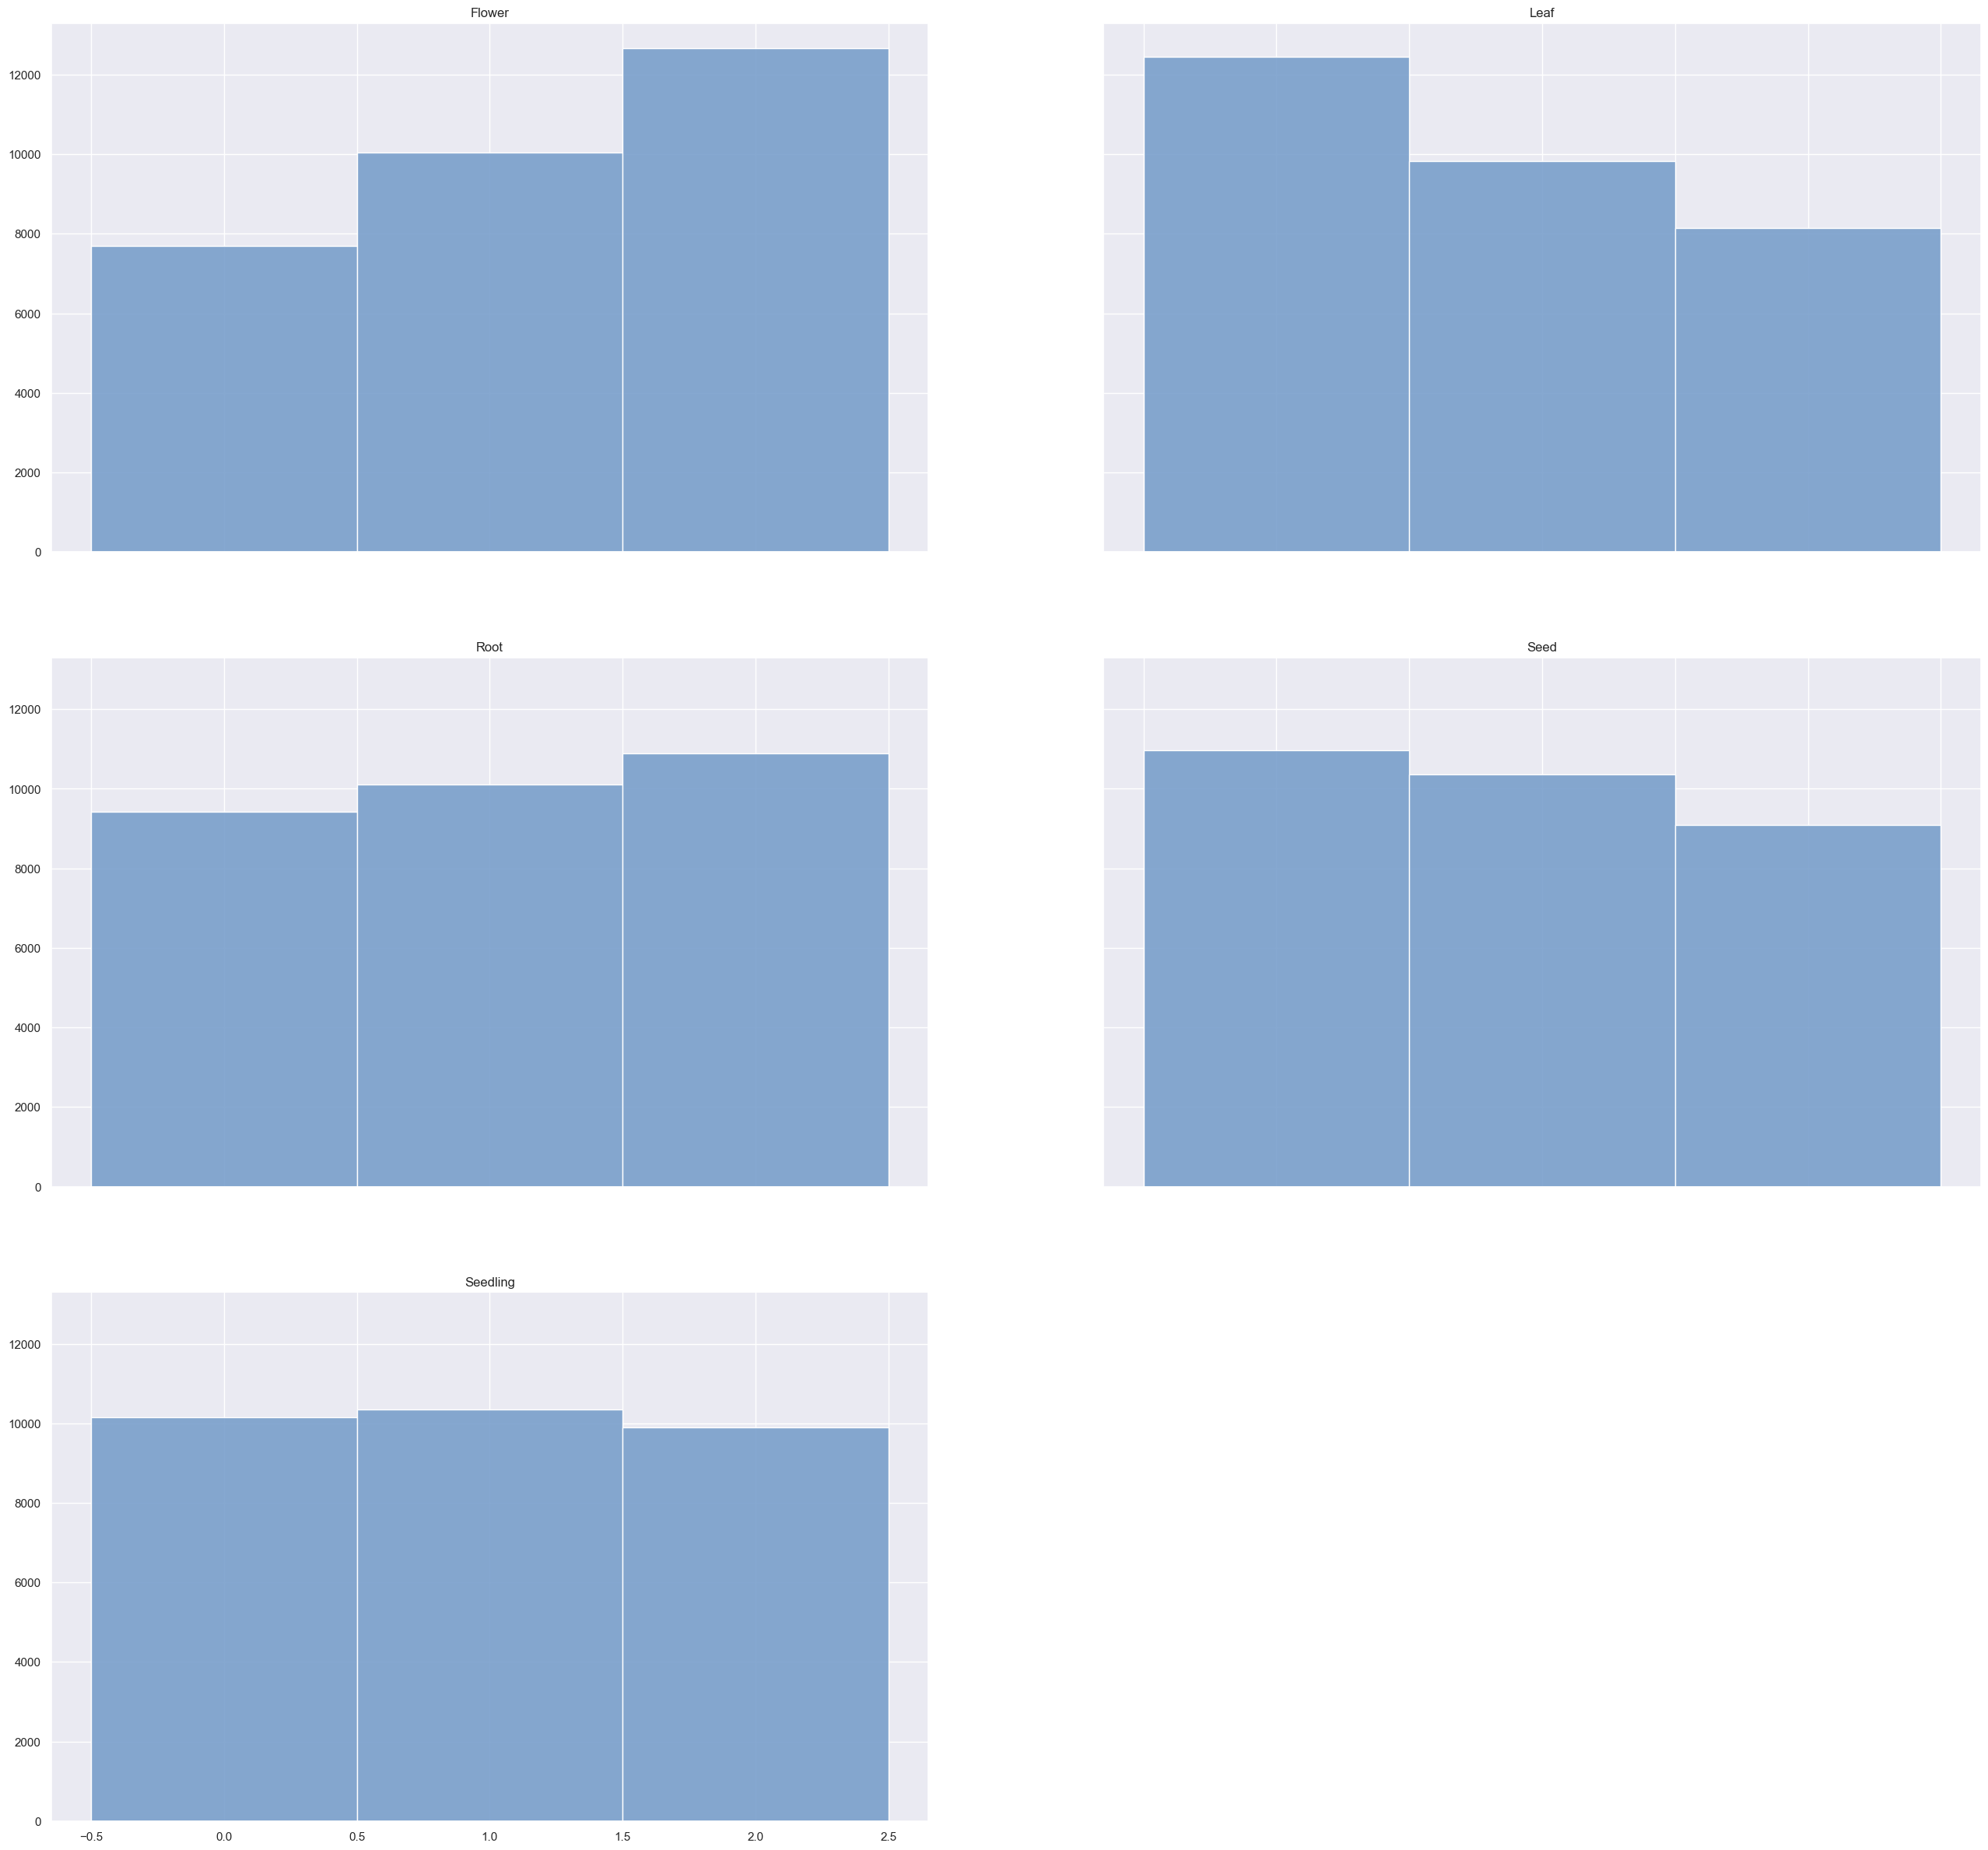

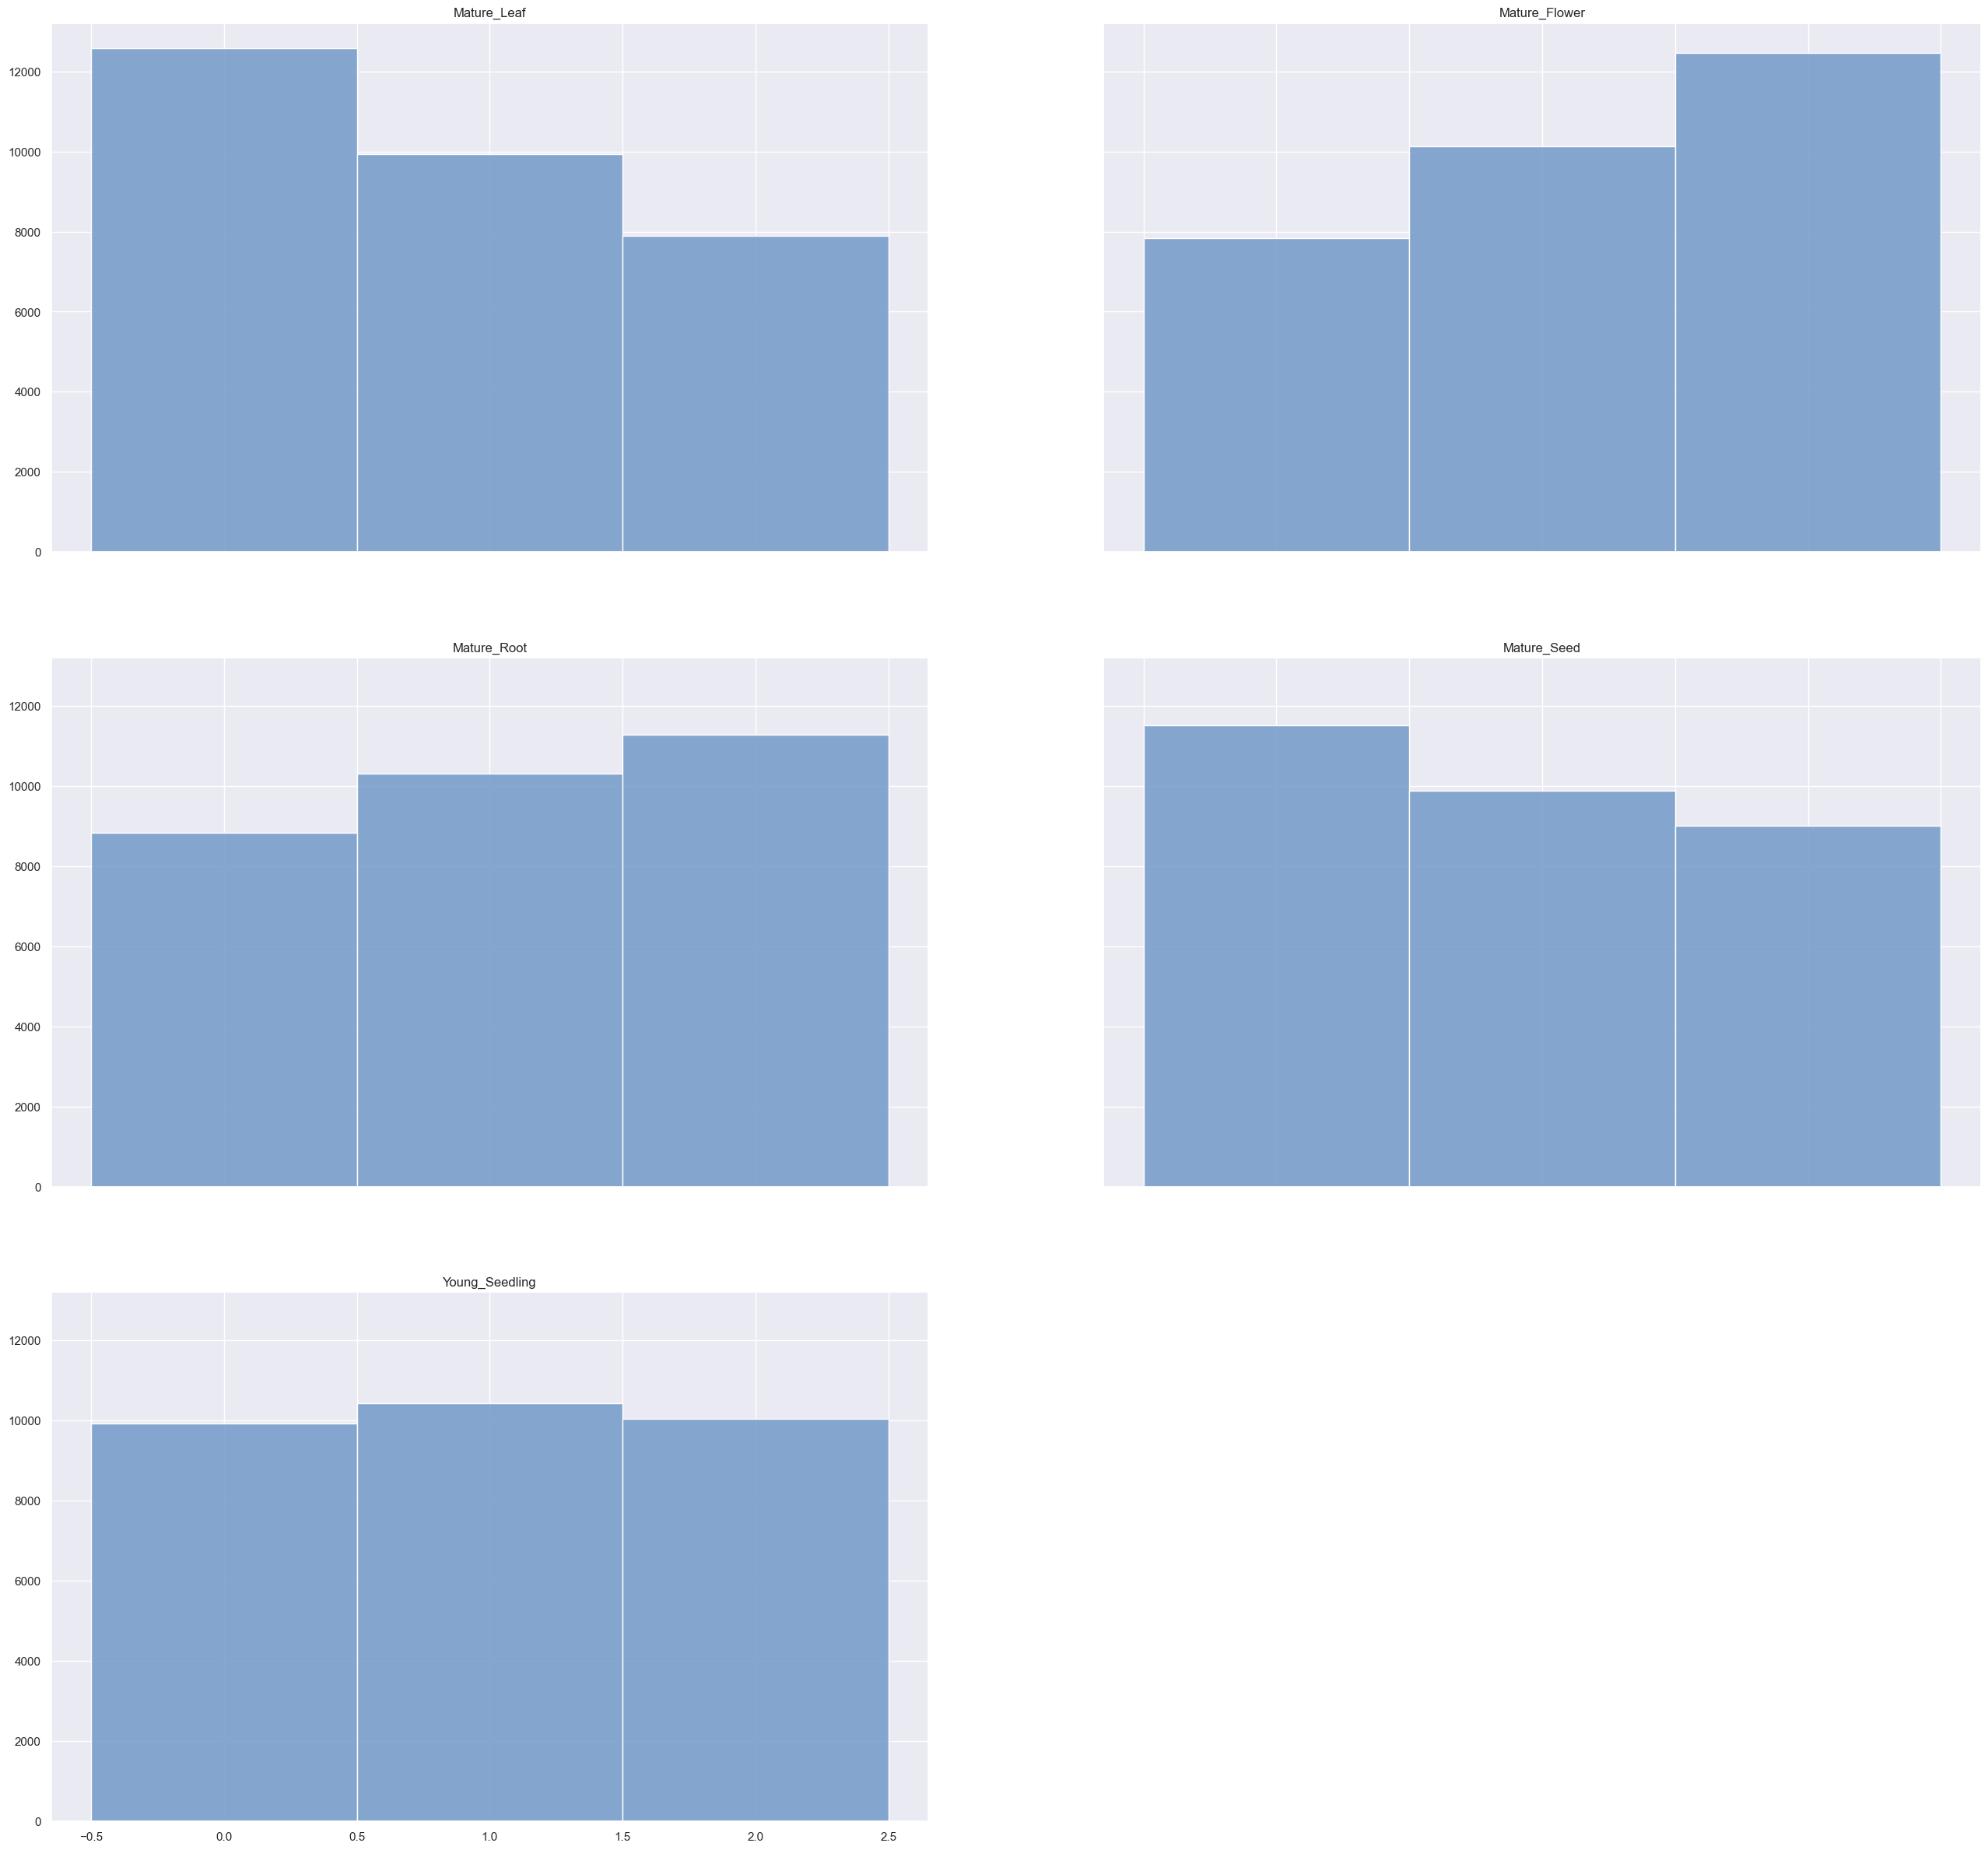

In [18]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-mean')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'group',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-group-mean')
)

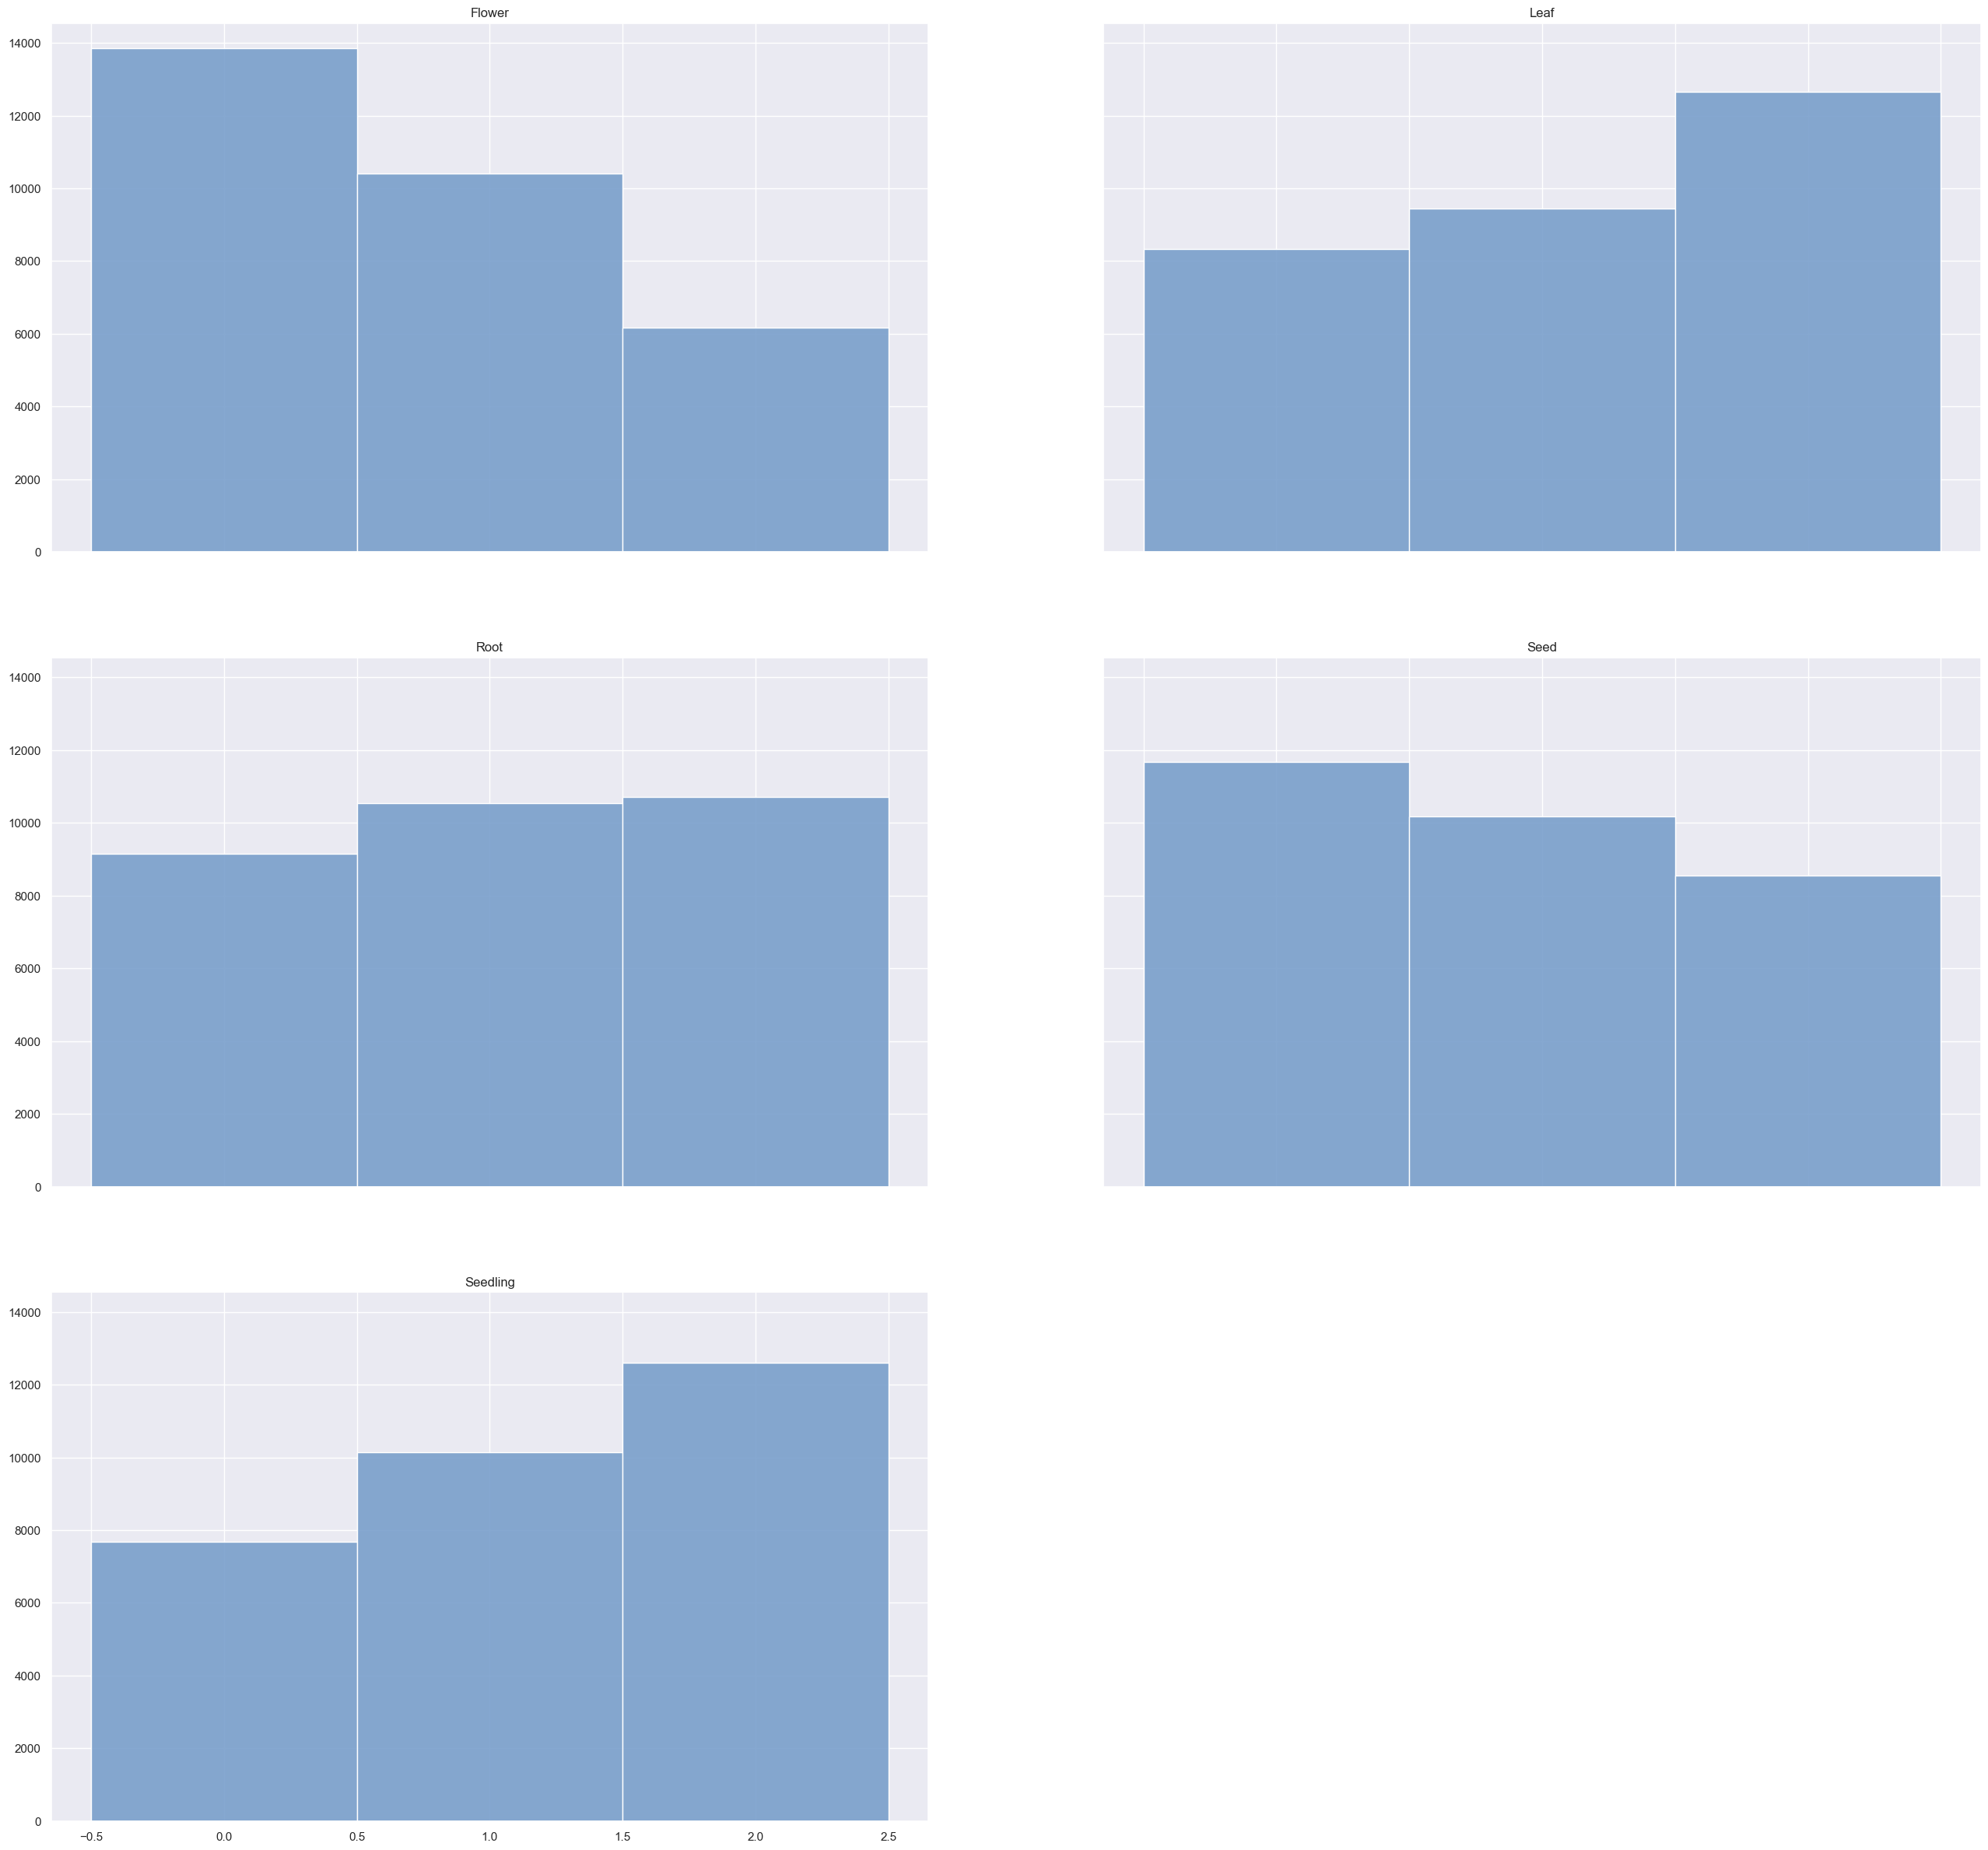

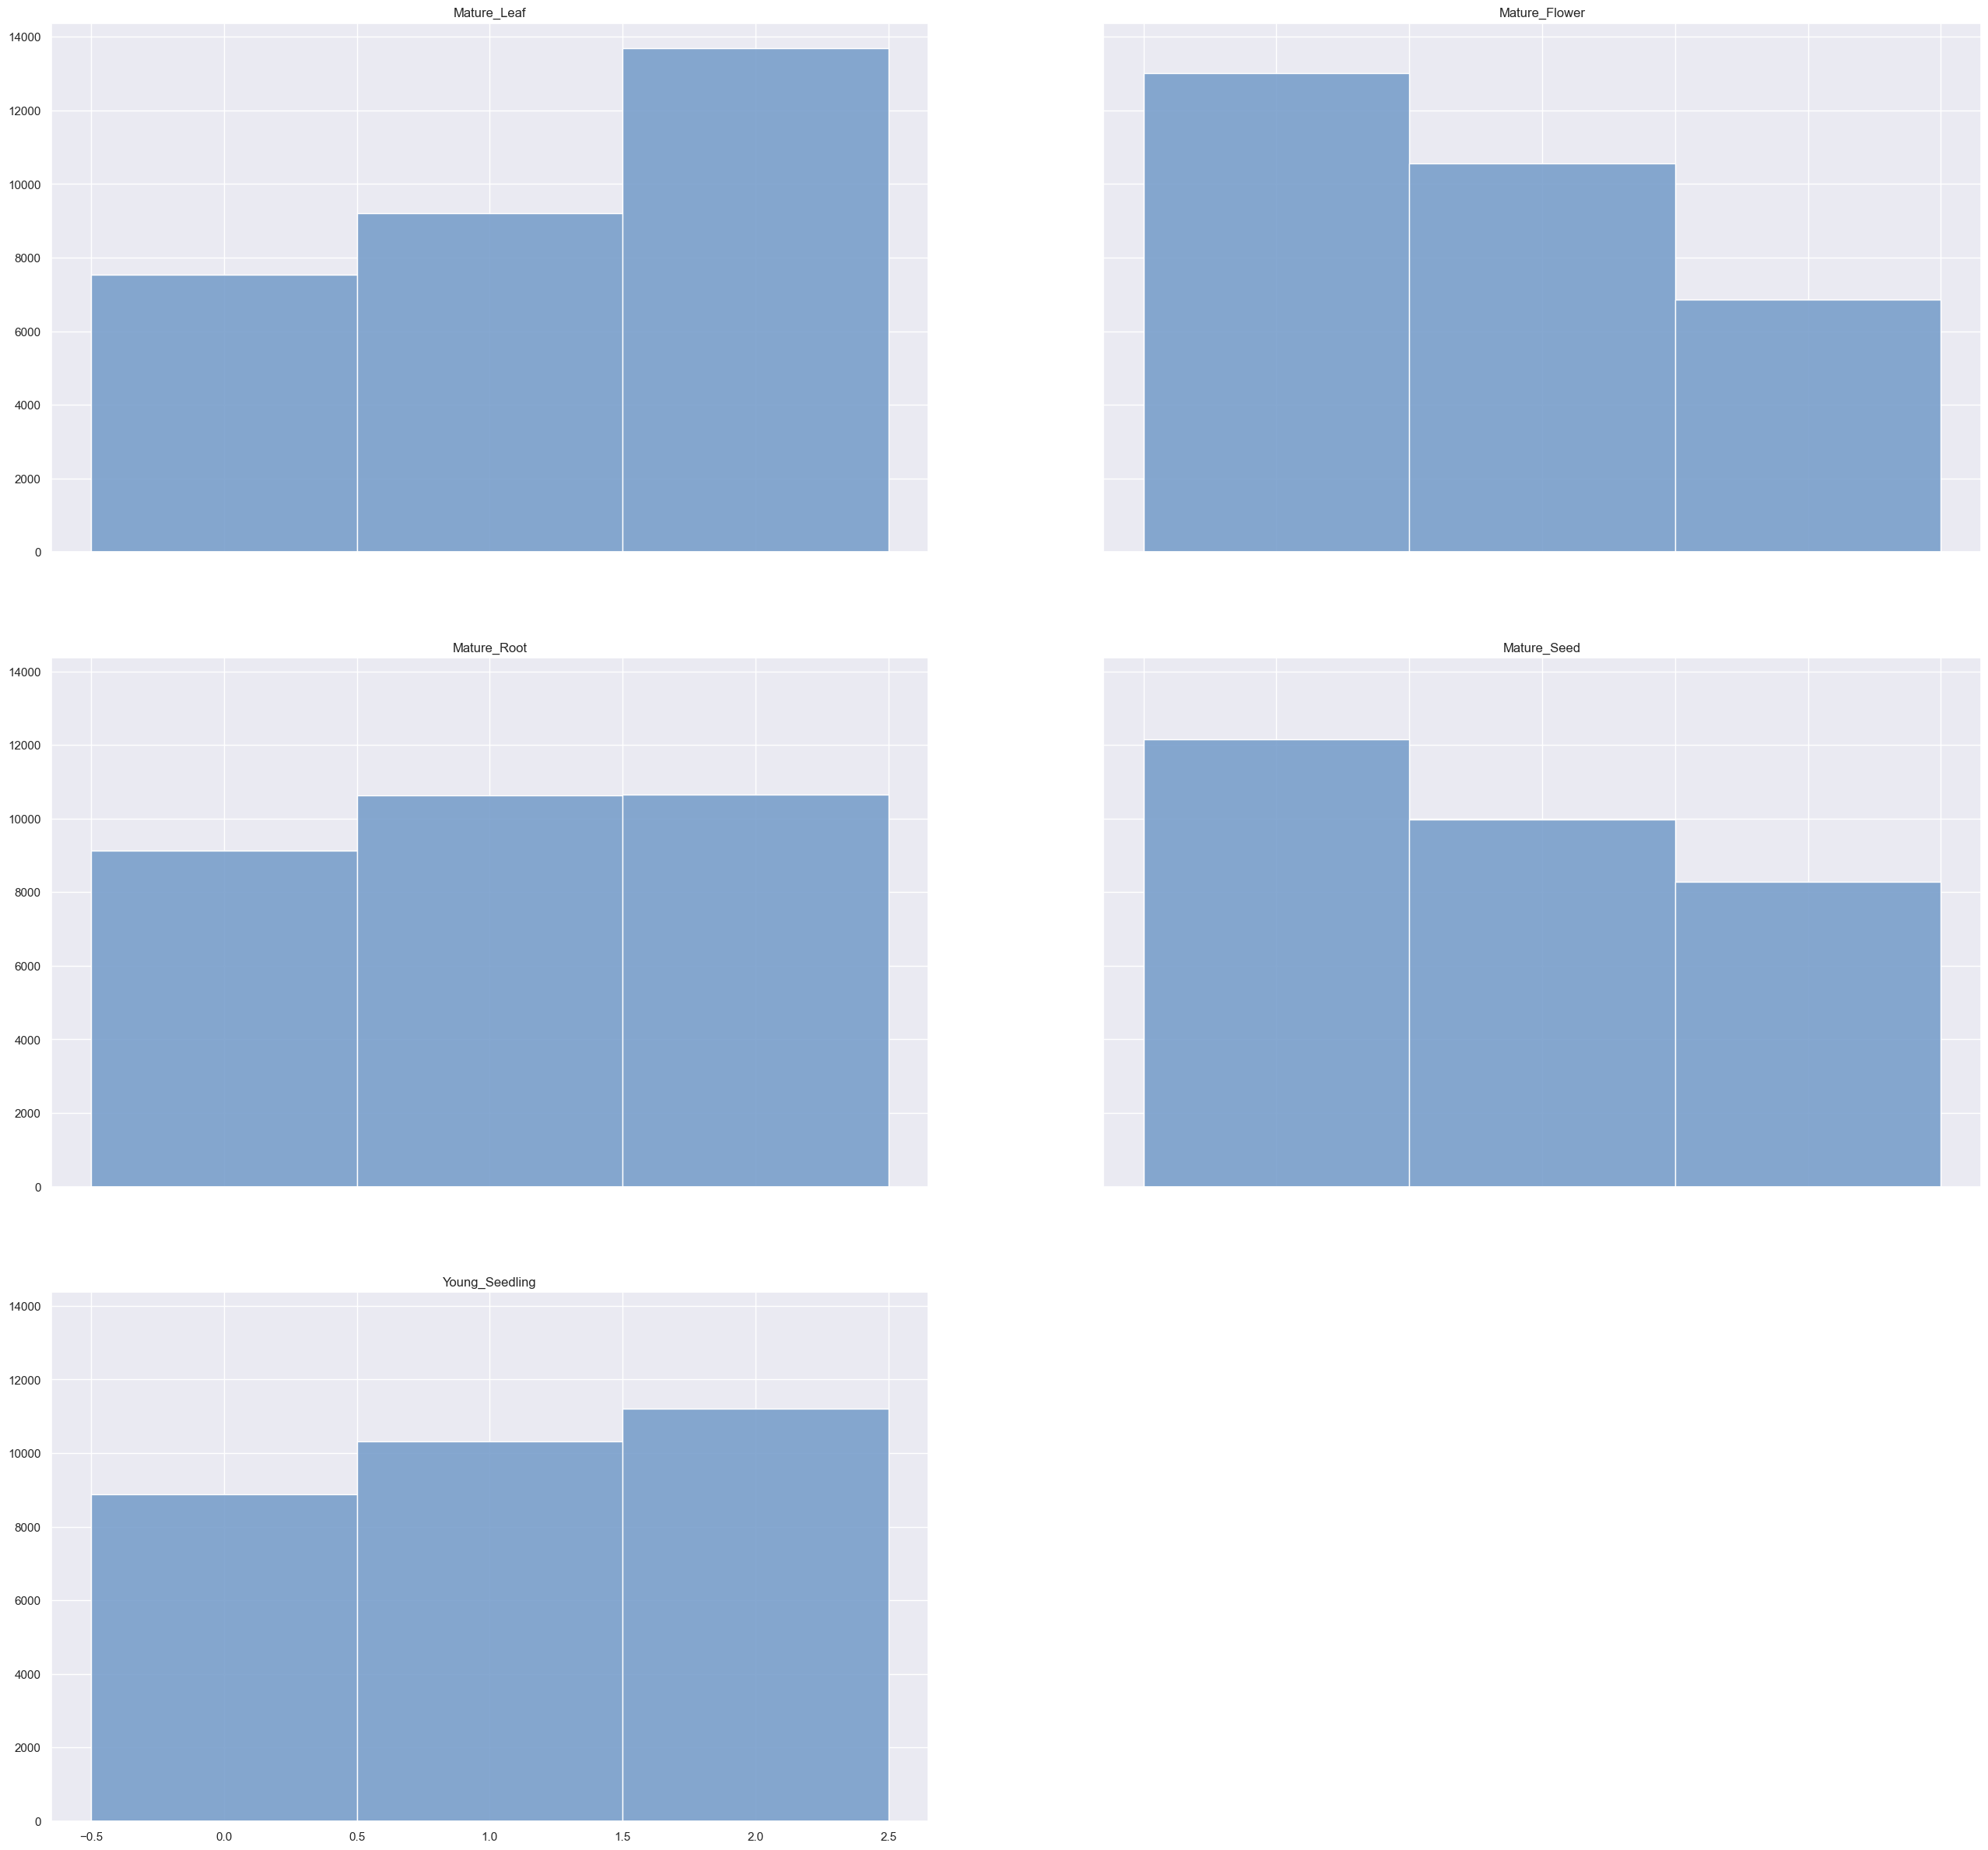

In [19]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'max',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-max')
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'group',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-group-max')
)

## 3.2 Save

In [20]:
# Save the target transcript classification

data_writer.write_json(
	data     = labels,
	filename = os.path.join(OUT_DATA, 'target-labels.json')
)

# 4. Mapping

## 4.1 Average

In [21]:
# Create binarizers and mapping lookup

features_binarizer = dict()
features_grouped   = dict()
features_exploded  = dict()

transcripts = list(values.keys())
functions   = ['mean']
groups      = ['tissue', 'age', 'group', 'perturbation']

for group, function in itertools.product(groups, functions) :
	group_order = order[group]

	dataframe = DataFrame()
	binarizer = LabelBinarizer()
	binarizer = binarizer.fit(group_order)

	key   = f'{group}-{function}'
	group = group.capitalize()

	dataframe['ID']         = transcripts
	dataframe['Transcript'] = transcripts
	dataframe['TPM_Value']  = [values[x][key] for x in transcripts]
	dataframe['TPM_Label']  = [labels[x][key] for x in transcripts]
	dataframe[group]        = [group_order    for x in transcripts]

	features_grouped[key] = dataframe

	dataframe = dataframe.copy().explode(['TPM_Value', 'TPM_Label', group])
	dataframe = dataframe.reset_index(drop = True)

	dataframe['TPM_Label'] = dataframe['TPM_Label'].astype('category')
	dataframe[group]       = dataframe[group].astype('category')

	features_binarizer[key] = binarizer
	features_exploded[key]  = dataframe

In [22]:
# Show keys and labels

for key in features_binarizer.keys() :
	classes = features_binarizer[key].classes_

	if len(classes) > 8 :
		print('{:17s} : {} ...'.format(key, classes[:8]))
	else :
		print('{:17s} : {}'.format(key, classes))

tissue-mean       : ['flower' 'leaf' 'root' 'seed' 'seedling']
age-mean          : ['mature' 'missing' 'seed' 'young']
group-mean        : ['mature_flower' 'mature_leaf' 'mature_root' 'mature_seed' 'young_seedling']
perturbation-mean : ['chemical' 'control' 'dna' 'environmental' 'mechanical' 'mutant' 'unstressed']


In [23]:
# Save binarizers and mapping lookup

data_writer.write_pickle(
	data     = features_grouped,
	filename = os.path.join(OUT_DATA, f'mapping-mean-grouped.pkl')
)

data_writer.write_pickle(
	data     = features_exploded,
	filename = os.path.join(OUT_DATA, f'mapping-mean-exploded.pkl')
)

## 4.2 Exact

In [24]:
raise Warning('Hardcoded Execution Stop - Volatile Code :: DataFrame Explode :: Tens Of Millions Of Data')

Warning: Hardcoded Execution Stop - Volatile Code :: DataFrame Explode :: Tens Of Millions Of Data

In [ ]:
# Get n samples per transcript

samples = list()
amount  = 2

for _, x in anndata.obs.groupby('Tissue') :
	samples.extend(x.sample(n = amount).index.tolist())

anndata = anndata[samples, :]

In [ ]:
# Create mapping and explode per sample

label_tissue       = anndata.obs['Tissue'].to_numpy()
label_perturbation = anndata.obs['Perturbation'].to_numpy()
label_age          = anndata.obs['Age'].to_numpy()
label_group        = anndata.obs['Group'].to_numpy()

samples     = anndata.obs.index.tolist()
transcripts = anndata.var.index.tolist()

dataframe = DataFrame()

dataframe['Sample']       = samples
dataframe['Trancript']    = [transcripts               for i in range(len(onehot_tissue))]
dataframe['TPM_Value']    = [anndata[i, :]             for i in samples]
dataframe['Tissue']       = [onehot_tissue[i, :]       for i in range(len(onehot_tissue))]
dataframe['Age']          = [onehot_age[i, :]          for i in range(len(onehot_tissue))]
dataframe['Perturbation'] = [onehot_perturbation[i, :] for i in range(len(onehot_tissue))]

dataframe = dataframe.explode(['Trancript', 'TPM_Value'])

In [ ]:
# Combine exact targets and features

targets  = dict()
features = dict()

for _, row in dataframe.iterrows() :
	feature = list()

	feature.extend(list(row['Tissue']))
	feature.extend(list(row['Age']))
	feature.extend(list(row['Perturbation']))
	feature.extend(list(row['Group']))

    sample = row['Sample'] + '?' + row['Trancript']

    targets[sample]  = row['TPM_Value']
    features[sample] = numpy.array(feature, dtype = int)

In [ ]:
# Save exact targets and features

data_writer.write_npz(
	data     = targets,
	filename = os.path.join(OUT_DATA, 'values-exact')
)

data_writer.write_npz(
	data     = features,
	filename = os.path.join(OUT_DATA, 'features-exact')
)